# LSTM With HPO

- 5-Fold CV with HPO
- 3 Metrics: MAPE, RMSE, MAE
- Predict 24 hours in the future using examples of the past 7 days
- Hourly temperature averages
- Minute detail weather data from a Berlin weather station
- Test set is the 2025 weather data (not yet scraped)

(BME860 sensor data published to a friend's website, see scraping script for details)

In [32]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

Setup

In [33]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: Tesla V100S-PCIE-32GB


In [34]:
# Read in data
years = ["2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("./data/2023_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"./data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data.set_index("ISO Time", inplace=True)
hourly_avg = all_data.resample("H").mean()

Data Collected


<Figure size 1400x500 with 0 Axes>

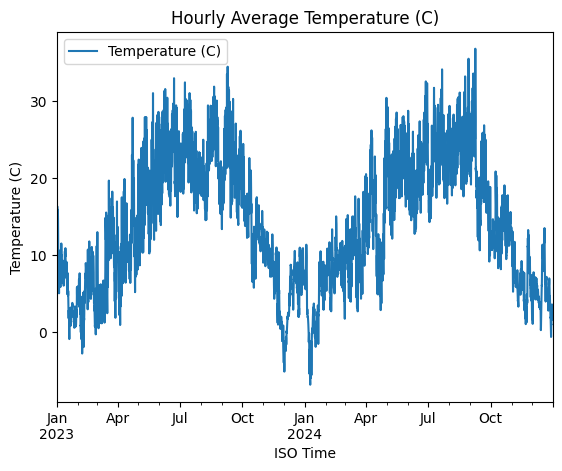

<Figure size 1400x500 with 0 Axes>

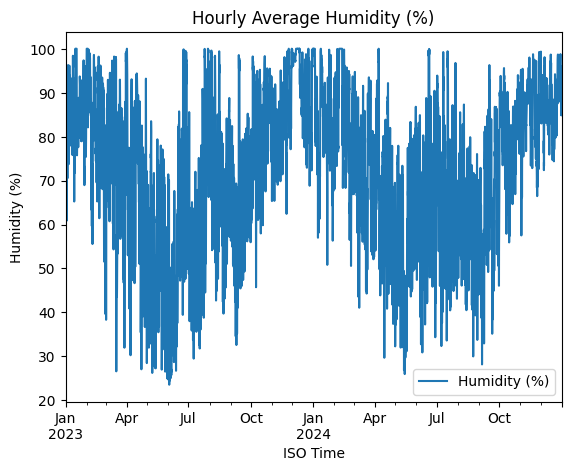

<Figure size 1400x500 with 0 Axes>

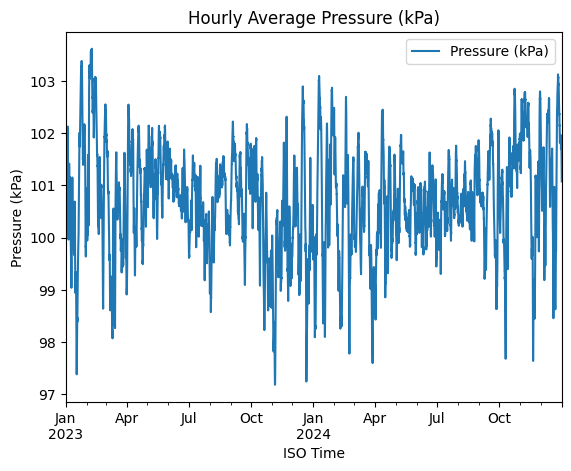

<Figure size 1400x500 with 0 Axes>

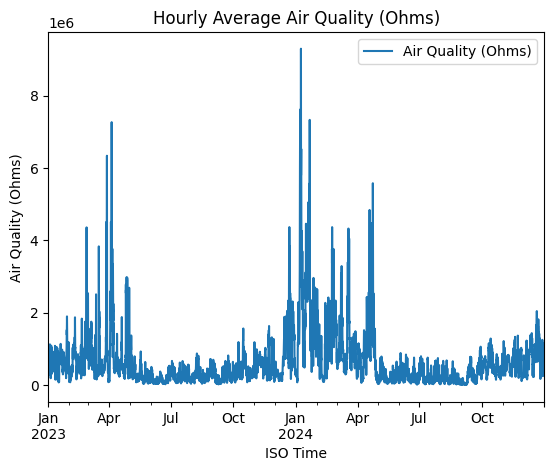

In [35]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    hourly_avg.plot(y=variable)
    plt.title(f"Hourly Average {variable}")
    plt.ylabel(variable)
    plt.show()

In [36]:
data = hourly_avg["Temperature (C)"].dropna()
data

ISO Time
2023-01-01 00:00:00    16.246780
2023-01-01 01:00:00    16.207143
2023-01-01 02:00:00    16.215254
2023-01-01 03:00:00    16.012833
2023-01-01 04:00:00    15.748305
                         ...    
2024-12-31 19:00:00     3.260667
2024-12-31 20:00:00     3.269362
2024-12-31 21:00:00     3.188462
2024-12-31 22:00:00     3.008491
2024-12-31 23:00:00     2.883103
Name: Temperature (C), Length: 17542, dtype: float64

Model Definition

In [37]:
# Scale Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.to_numpy().reshape(-1,1))

# Hyper Parameters
horizon = 24
look_back = horizon * 7  # 1 week lookback
n_splits = 5
epochs = 50
test_percent = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def create_dataset(dataset, look_back, horizon=24):
    X, y = [], []
    for i in range(len(dataset) - look_back - horizon + 1):
        X.append(dataset[i:i+look_back, 0])                # Input: 168 past hours
        y.append(dataset[i+look_back : i+look_back+horizon, 0])  # Output: next 24 hours sequence
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled, look_back, horizon)

######################################################
# This will be changed when we collect the 2025 data #
######################################################

# Add channel dimension before splitting (input shape: (samples, time_steps, 1))
X = X[:, :, np.newaxis]  # shape: (N, 168, 1)
y = y[:, :, np.newaxis]  # shape: (N, 24, 1)

# Split
split_index = int((1.0-test_percent) * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert test set to tensors
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=24):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)  # output 24 values at once
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        out, _ = self.lstm(x)           # out shape: (batch, seq_len, hidden_size)
        out = self.dropout(out[:, -1, :])  # take output from last time step only
        out = self.linear(out)          # map to 24 outputs
        out = out.unsqueeze(2)          # reshape to (batch, 24, 1)
        return out

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

cuda


Train

In [38]:
def objective(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    wt_decay = trial.suggest_float('wt_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 30
    patience = 5  # number of epochs to wait for improvement before stopping

    tscv = TimeSeriesSplit(n_splits=5)

    mape_folds = []
    rmse_folds = []
    mae_folds = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_train_s, X_val_s = X_train[train_idx], X_train[val_idx]
        y_train_s, y_val_s = y_train[train_idx], y_train[val_idx]

        X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train_s, dtype=torch.float32).to(device)
        X_val_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
        y_val_t = torch.tensor(y_val_s, dtype=torch.float32).to(device)

        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=horizon).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wt_decay)
        loss_fn = nn.MSELoss()

        best_val_mape = float('inf')
        epochs_no_improve = 0

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                y_pred = model(X_val_t).cpu().numpy()
                y_val_np = y_val_t.cpu().numpy()

                y_pred_reshaped = y_pred.reshape(-1, 1)
                y_val_reshaped = y_val_np.reshape(-1, 1)

                y_pred_inv = scaler.inverse_transform(y_pred_reshaped)
                y_val_inv = scaler.inverse_transform(y_val_reshaped)

                val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)

            # Early stopping check
            if val_mape < best_val_mape:
                best_val_mape = val_mape
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} on fold {fold+1}")
                break

        # After training, compute all metrics on val set with best model (already current)
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_t).cpu().numpy()
            y_val_np = y_val_t.cpu().numpy()

            y_pred_reshaped = y_pred.reshape(-1, 1)
            y_val_reshaped = y_val_np.reshape(-1, 1)

            y_pred_inv = scaler.inverse_transform(y_pred_reshaped)
            y_val_inv = scaler.inverse_transform(y_val_reshaped)

            rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
            mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)
            mae = mean_absolute_error(y_val_inv, y_pred_inv)

            mape_folds.append(mape)
            rmse_folds.append(rmse)
            mae_folds.append(mae)

        # Optional: prune unpromising trials based on intermediate results
        trial.report(np.mean(mape_folds), fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr("rmse_mean", np.mean(rmse_folds))
    trial.set_user_attr("mae_mean", np.mean(mae_folds))

    return np.mean(mape_folds)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5, timeout=900)  # 30 trials or 1 hour limit

print("Best trial:")
trial = study.best_trial

print(f"  MAPE: {trial.value:.4f}")
print(f"  RMSE: {trial.user_attrs['rmse_mean']:.4f}")
print(f"  MAE: {trial.user_attrs['mae_mean']:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-13 07:24:39,884] A new study created in memory with name: no-name-5b2f1566-24b9-47ea-af9f-2c5eca18f424


Early stopping at epoch 9 on fold 1
Early stopping at epoch 10 on fold 2
Early stopping at epoch 17 on fold 3
Early stopping at epoch 6 on fold 4


[I 2025-06-13 07:25:28,761] Trial 0 finished with value: 72.67537504434586 and parameters: {'hidden_size': 116, 'num_layers': 3, 'lr': 0.0002451542213647868, 'wt_decay': 0.002220615628230686, 'batch_size': 32}. Best is trial 0 with value: 72.67537504434586.


Early stopping at epoch 7 on fold 5
Early stopping at epoch 9 on fold 1
Early stopping at epoch 6 on fold 2
Early stopping at epoch 6 on fold 3
Early stopping at epoch 9 on fold 4


[I 2025-06-13 07:25:54,477] Trial 1 finished with value: 190.59243381023407 and parameters: {'hidden_size': 92, 'num_layers': 2, 'lr': 0.00683669731736786, 'wt_decay': 0.005677980290793505, 'batch_size': 32}. Best is trial 0 with value: 72.67537504434586.


Early stopping at epoch 12 on fold 5
Early stopping at epoch 18 on fold 1
Early stopping at epoch 20 on fold 2
Early stopping at epoch 27 on fold 3
Early stopping at epoch 15 on fold 4


[I 2025-06-13 07:27:31,000] Trial 2 finished with value: 41.792612969875336 and parameters: {'hidden_size': 94, 'num_layers': 2, 'lr': 0.00010169335029446443, 'wt_decay': 0.00011911768918436738, 'batch_size': 16}. Best is trial 2 with value: 41.792612969875336.


Early stopping at epoch 14 on fold 5
Early stopping at epoch 9 on fold 1
Early stopping at epoch 10 on fold 2
Early stopping at epoch 7 on fold 3
Early stopping at epoch 12 on fold 4


[I 2025-06-13 07:27:45,257] Trial 3 finished with value: 57.02765643596649 and parameters: {'hidden_size': 85, 'num_layers': 1, 'lr': 0.0062182150913681795, 'wt_decay': 0.0007404463679921095, 'batch_size': 64}. Best is trial 2 with value: 41.792612969875336.


Early stopping at epoch 10 on fold 5
Early stopping at epoch 9 on fold 1
Early stopping at epoch 18 on fold 2
Early stopping at epoch 9 on fold 3
Early stopping at epoch 13 on fold 4


[I 2025-06-13 07:28:00,090] Trial 4 finished with value: 39.26042839884758 and parameters: {'hidden_size': 56, 'num_layers': 1, 'lr': 0.0025728813315119134, 'wt_decay': 0.0002324125750645871, 'batch_size': 64}. Best is trial 4 with value: 39.26042839884758.


Early stopping at epoch 7 on fold 5
Best trial:
  MAPE: 39.2604
  RMSE: 3.0511
  MAE: 2.4120
  Params: 
    hidden_size: 56
    num_layers: 1
    lr: 0.0025728813315119134
    wt_decay: 0.0002324125750645871
    batch_size: 64


Get best model

In [39]:
best_params = trial.params

model = LSTMModel(
    input_size=1,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=horizon
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['wt_decay'])
loss_fn = nn.MSELoss()

# Train on all available data - We have the CV loss for this model too.
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Train the model
model.train()
for epoch in range(epochs):
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

Evaluation

In [40]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy()
    y_true = y_test_t.cpu().numpy()

# Reshape to 1D for inverse scaling
y_pred_reshaped = y_pred.reshape(-1, 1)
y_true_reshaped = y_true.reshape(-1, 1)

y_pred_inv = scaler.inverse_transform(y_pred_reshaped).reshape(-1, horizon)
y_true_inv = scaler.inverse_transform(y_true_reshaped).reshape(-1, horizon)



Plots of a week of hourly temperature predictions vs true

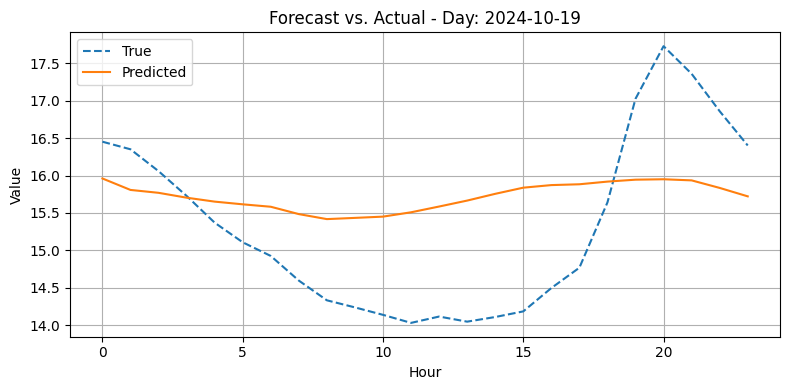

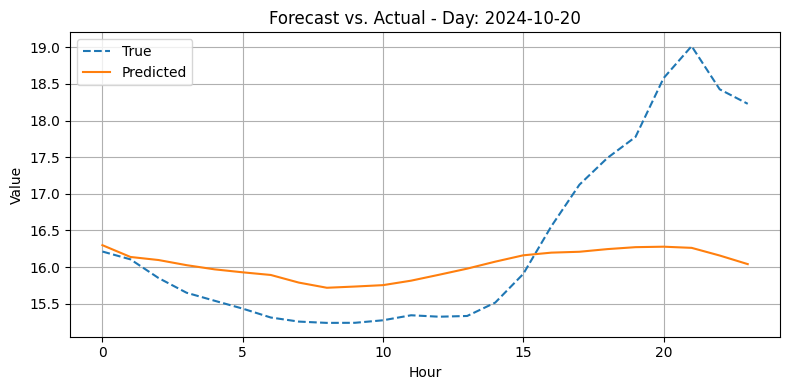

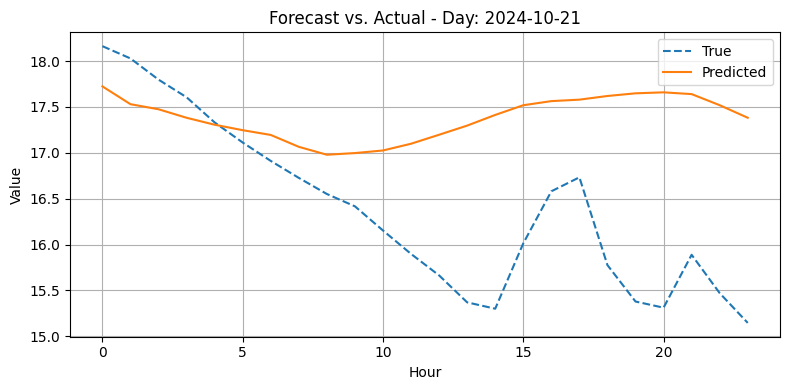

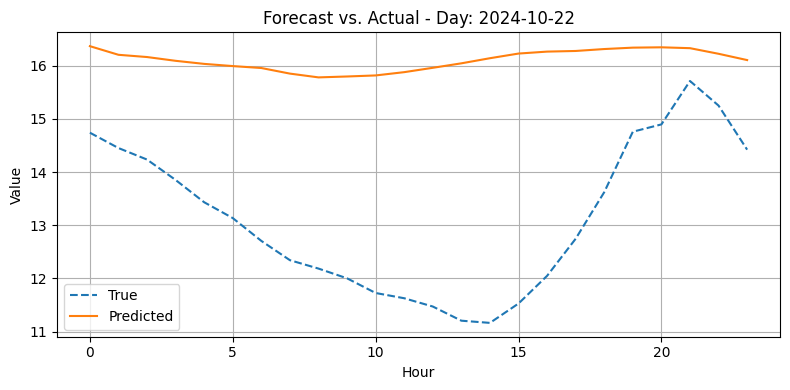

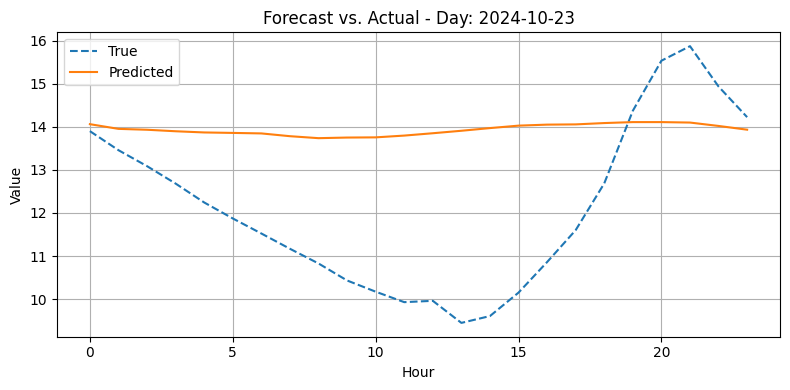

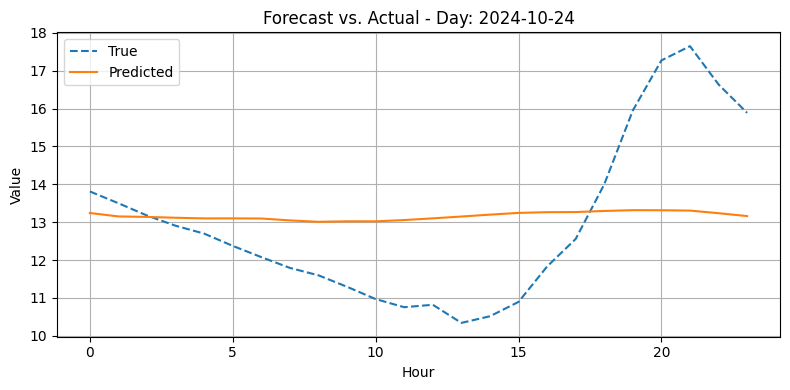

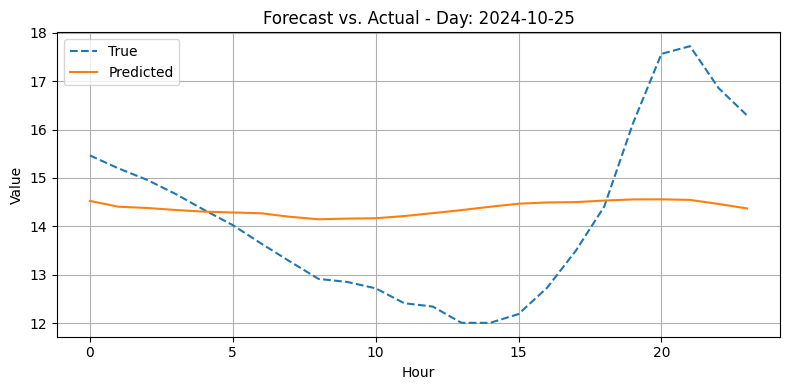

In [41]:
days_to_plot = 7
start_time = data.index[0] + pd.Timedelta(hours=look_back)

for i in range(days_to_plot):
    # Each i corresponds to a new day ahead forecast
    forecast_index = len(X) - len(X_test) + i*24  # global index of the forecast
    forecast_time = start_time + pd.Timedelta(hours=forecast_index)
    forecast_day = forecast_time.floor('D')  # get the date part only (start of day)

    plt.figure(figsize=(8, 4))
    plt.plot(range(horizon), y_true_inv[i*24].squeeze(), label='True', linestyle='dashed')
    plt.plot(range(horizon), y_pred_inv[i*24].squeeze(), label='Predicted')
    plt.title(f'Forecast vs. Actual - Day: {forecast_day.strftime("%Y-%m-%d")}')
    plt.xlabel('Hour')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Test set metrics

In [42]:
rmse = np.sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
mae = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())
mape = mean_absolute_percentage_error(y_true_inv.flatten(), y_pred_inv.flatten())

print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test MAPE: {mape:.2f}%')

Test RMSE: 1.8246
Test MAE: 1.4065
Test MAPE: 43.26%
